# PyGEM glacier thickness/bed inversion using OGGM

Brandon Tober<br>

30MAY2025<br>

This notebook goes through ice thickness inversion using OGGM's workflows, but with PyGEM's mass balance model. This is typically done for all glacier's in a given region simultaneously (see [this OGGM tutorial](https://tutorials.oggm.org/stable/notebooks/tutorials/inversion.html)), to find a Glen's A creep parameter that allows for the total regional ice volume from inversion to best match the regional reference ice volume (from Farinotti et al. 2019).  The only departure from OGGM's workflow and preprocessing here is that we pass PyGEM's mass balance model, and we ensure that debris is added to the flowline objects so that PyGEM's mass balance model can account for debris cover accordingly.

This notebook accompanies PyGEM's `run_inversion.py` script for demonstrative purposes. The resulting glacier directory data will resemble the state of [OGGM's level 3](https://tutorials.oggm.org/stable/notebooks/tutorials/building_the_prepro_gdirs.html#level-3) preprocessing, however using PyGEM's mass balance model instead of OGGM's.

In [1]:
### imports ###
import os
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oggm import cfg, tasks, workflow
import pygem.pygem_modelsetup as modelsetup
from pygem import class_climate
from pygem.massbalance import PyGEMMassBalance_wrapper
from pygem.oggm_compat import update_cfg
from pygem.shop import debris, mbdata
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.

# set some plotting defaults
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8
cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = (
    f'{pygem_prms["root"]}/{pygem_prms["oggm"]["oggm_gdir_relpath"]}'
)

# SETUP

In [2]:
# OGGM configuration settings
update_cfg({'continue_on_error': True}, 'PARAMS')
update_cfg({'use_multiprocessing': True}, 'PARAMS')
update_cfg({'has_internet': True}, 'PARAMS')

In [3]:
# Glacier Directory initialization for RGIId's of interest. Note, for inversion, we likely want all glaciers
# in a given region, but for testing maybe just a handful?

main_glac_rgi = modelsetup.selectglaciersrgitable(rgi_regionsO1=[6])        # testing with RGI region 6 since it's smaller
# main_glac_rgi = main_glac_rgi[main_glac_rgi.RGIId=="RGI60-06.00000"]      # testing with a single glacier (uncomment if desired)
rgi_ids = main_glac_rgi['RGIId'].tolist()
# initialize all glacier directories (from level 2 OGGM preprocessing)
# note, this wipes preexisting gdirs and can take some time to download the data
gdirs = workflow.init_glacier_directories(
    rgi_ids,
    from_prepro_level=2,
    prepro_border=cfg.PARAMS['border'],
    prepro_base_url=pygem_prms['oggm']['base_url'],
    prepro_rgi_version='62',
);

This study is focusing on 568 glaciers in region [6]


In [4]:
# PyGEM setup - model datestable, climate data import, prior model parameters

# model dates
dt = modelsetup.datesmodelrun(
    startyear=1979, endyear=2019
)  # will have to cover the time period of inversion (2000-2019) and spinup (1979-~2010 by default). Note, 1940 startyear just in case we want to run spinup starting earlier.
# load climate data
ref_clim = class_climate.GCM(name='ERA5')

# Air temperature [degC]
temp, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.temp_fn, ref_clim.temp_vn, main_glac_rgi, dt
)
# Precipitation [m]
prec, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.prec_fn, ref_clim.prec_vn, main_glac_rgi, dt
)
# Elevation [m asl]
elev = ref_clim.importGCMfxnearestneighbor_xarray(
    ref_clim.elev_fn, ref_clim.elev_vn, main_glac_rgi
)
# Lapse rate [degC m-1]
lr, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.lr_fn, ref_clim.lr_vn, main_glac_rgi, dt
)

# load prior regionally averaged modelprms (from Rounce et al. 2023)
priors_df = pd.read_csv(
    pygem_prms['root'] + '/Output/calibration/' + pygem_prms['calib']['priors_reg_fn']
)

# loop through gdirs and add `glacier_rgi_table`, `historical_climate`, `dates_table` and `modelprms` attributes to each glacier directory
for i, gd in enumerate(gdirs):
    # Select subsets of data
    gd.glacier_rgi_table = main_glac_rgi.loc[main_glac_rgi.index.values[i], :]
    # Add climate data to glacier directory (first inversion data)
    gd.historical_climate = {
        'elev': elev[i],
        'temp': temp[i, :],
        'tempstd': np.zeros(temp[i, :].shape),
        'prec': prec[i, :],
        'lr': lr[i, :],
    }
    gd.dates_table = dt

    # get modelprms from regional priors
    priors_idx = np.where(
        (priors_df.O1Region == gd.glacier_rgi_table['O1Region'])
        & (priors_df.O2Region == gd.glacier_rgi_table['O2Region'])
    )[0][0]
    tbias_mu = float(priors_df.loc[priors_idx, 'tbias_mean'])
    kp_mu = float(priors_df.loc[priors_idx, 'kp_mean'])
    gd.modelprms = {
        'kp': kp_mu,
        'tbias': tbias_mu,
        'ddfsnow': pygem_prms['calib']['MCMC_params']['ddfsnow_mu'],
        'ddfice': pygem_prms['calib']['MCMC_params']['ddfsnow_mu']
        / pygem_prms['sim']['params']['ddfsnow_iceratio'],
        'precgrad': pygem_prms['sim']['params']['precgrad'],
        'tsnow_threshold': pygem_prms['sim']['params']['tsnow_threshold'],
    }

# PREPROCESSING

In [5]:
task_list = [
    tasks.process_climate_data,     # process climate_hisotrical data to gdir
    mbdata.mb_df_to_gdir,           # process mass balance calibration data to gdir
    debris.debris_to_gdir,          # process debris data to gdir
    debris.debris_binned,           # add debris to inversion flowlines
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs);

# INVERSION and GLEN'S A CALIBRATION

In [6]:
# process mb_calib data from geodetic mass balance
workflow.execute_entity_task(
    tasks.mb_calibration_from_geodetic_mb,
    gdirs,
    informed_threestep=True,
    overwrite_gdir=True,
);

In [7]:
##############################
### INVERSION - no calving ###
##############################
# note, PyGEMMassBalance_wrapper is passed to `tasks.apparent_mb_from_any_mb` as the `mb_model_class` so that PyGEMs mb model is used for inversion
workflow.execute_entity_task(
    tasks.apparent_mb_from_any_mb,
    gdirs,
    mb_model_class=partial(
        PyGEMMassBalance_wrapper,
        fl_str='inversion_flowlines',
        option_areaconstant=True,
        inversion_filter=True,
    ),
);
# add debris data to flowlines
workflow.execute_entity_task(
    debris.debris_binned, gdirs, fl_str='inversion_flowlines'
);

In [8]:
##########################
### CALIBRATE GLEN'S A ###
##########################
# fit ice thickness to consensus estimates to find "best" Glen's A
cdf = workflow.calibrate_inversion_from_consensus(
        gdirs,
        apply_fs_on_mismatch=True,
        error_on_mismatch=False,  # if you running many glaciers some might not work
        filter_inversion_output=True,  # this partly filters the overdeepening due to
        # the equilibrium assumption for retreating glaciers (see. Figure 5 of Maussion et al. 2019)
        volume_m3_reference=None,  # here you could provide your own total volume estimate in m3
);

More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.
More than one grid point has zero or negative flux: this should not happen.


In [9]:
################################
### INVERSION - with calving ###
################################
cfg.PARAMS['use_kcalving_for_inversion'] = True
for gdir in gdirs:
    # note, tidewater glacier inversion is not done in parallel since there's not currently a way to pass a different inversion_calving_k to each gdir
    if (
        gdir.glacier_rgi_table['TermType'] not in [1, 5]
        or not pygem_prms['setup']['include_frontalablation']
    ):
        continue

    # Load quality controlled frontal ablation data
    fp = f'{pygem_prms["root"]}/{pygem_prms["calib"]["data"]["frontalablation"]["frontalablation_relpath"]}/analysis/{pygem_prms["calib"]["data"]["frontalablation"]["frontalablation_cal_fn"]}'
    assert os.path.exists(fp), 'Calibrated calving dataset does not exist'
    calving_df = pd.read_csv(fp)
    calving_rgiids = list(calving_df.RGIId)

    # Use calibrated value if individual data available
    if gdir.rgi_id in calving_rgiids:
        calving_idx = calving_rgiids.index(gdir.rgi_id)
        calving_k = calving_df.loc[calving_idx, 'calving_k']
    # Otherwise, use region's median value
    else:
        calving_df['O1Region'] = [
            int(x.split('-')[1].split('.')[0]) for x in calving_df.RGIId.values
        ]
        calving_df_reg = calving_df.loc[
            calving_df['O1Region'] == int(gdir.rgi_id[6:8]), :
        ]
        calving_k = np.median(calving_df_reg.calving_k)

    # increase calving line for inversion so that later spinup will work
    cfg.PARAMS['calving_line_extension'] = 120
    # set inversion_calving_k
    cfg.PARAMS['inversion_calving_k'] = calving_k
    print(f'Running inversion for {gdir.rgi_id}, calving_k={calving_k}')

    tasks.find_inversion_calving_from_any_mb(
        gdir,
        mb_model=PyGEMMassBalance_wrapper(
            gdir,
            fl_str='inversion_flowlines',
            option_areaconstant=True,
            inversion_filter=True,
        ),
        glen_a=gdir.get_diagnostics()['inversion_glen_a'],
        fs=gdir.get_diagnostics()['inversion_fs'],
    );

In [10]:
######################
### POSTPROCESSING ###
######################
# finally create the dynamic flowlines
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

# add debris to model_flowlines
workflow.execute_entity_task(debris.debris_binned, gdirs, fl_str='model_flowlines');

Compare ITMIX regional ice volume with that the total inverted for using OGGM.

In [11]:
cdf.sum()

vol_itmix_m3        3.769574e+12
vol_bsl_itmix_m3    8.049952e+09
vol_oggm_m3         3.769373e+12
dtype: float64

Text(0, 0.5, 'vol_oggm_m3')

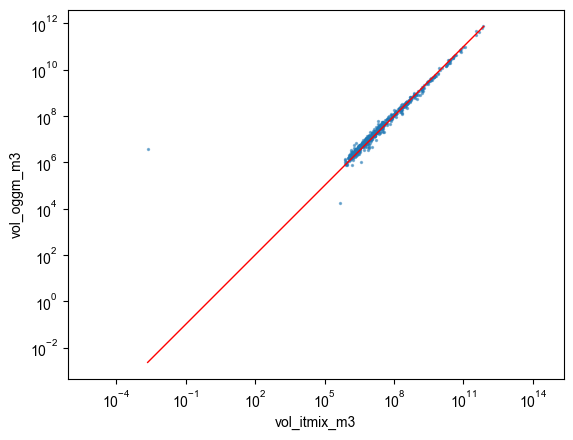

In [12]:
fig, ax = plt.subplots(1)

ax.scatter(cdf.vol_itmix_m3.values, cdf.vol_oggm_m3.values, alpha=0.5, s=2)

# Determine range for 1:1 line
min_val = min(cdf.vol_itmix_m3.min(), cdf.vol_oggm_m3.min())
max_val = max(cdf.vol_itmix_m3.max(), cdf.vol_oggm_m3.max())
# Plot 1:1 line
ax.plot([min_val, max_val], [min_val, max_val], 'r', lw=1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis('equal')
ax.set_xlabel('vol_itmix_m3')
ax.set_ylabel('vol_oggm_m3')

Check the calibrated Glen's A creep parameter value

In [13]:
gdirs[0].get_diagnostics()

{'dem_source': 'COPDEM90',
 'flowline_type': 'elevation_band',
 'apparent_mb_from_any_mb_residual': 2669.0860132471803,
 'inversion_glen_a': 3.774803215685941e-24,
 'inversion_fs': 0}

Note, all glaciers in the RGI 01-level region will have the same inversion_glen_a value.

We now have a workflow to run bed inversion using PyGEM's mass balance model.  Taking this workfow, can run inversion over glaciers of interest in parallel using a separate script `run_inversion.py`:

E.g.
```{python}
run_inversion -rgi_region01 6 -ncores 6
```

One more thing: If we wish to not use PyGEM's mass balance mode in inversion, simply remove the `mb_model_class` argument from the call to OGGM's `apparent_mb_from_any_mb` task in cell 7, and the `mb_model` argument from the call to OGGM's `find_inversion_calving_from_any_mb` task in cell 9 - both of these arguments pass the `PyGEMMassBalance_wrapper` object to OGGM, and are not necessary if we wish to use OGGM's own mass balance models.